In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import cv2
import os, copy
import time

import util_functions as fs
import symbol_path as pth
import imp
imp.reload(fs)
imp.reload(pth)

%matplotlib inline

In [2]:
#Read music sheets - Binary thresholding and resizing
sheets = fs.get_images('./data/test_sheets', resize_factor=1, threshold=200)

>>> Folder : ./data/test_sheets : 14 files
01 : ./data/test_sheets/Sample01.jpg : (1657, 1177)
02 : ./data/test_sheets/Sample02.jpg : (1353, 1174)
03 : ./data/test_sheets/fire.jpg : (3508, 2479)
04 : ./data/test_sheets/hush.jpg : (1100, 850)
05 : ./data/test_sheets/kookaburra.jpg : (1453, 2453)
06 : ./data/test_sheets/mary.jpg : (1288, 2456)
07 : ./data/test_sheets/p1 (1).jpg : (2339, 1653)
08 : ./data/test_sheets/p1.jpg : (2339, 1653)
09 : ./data/test_sheets/p1.png : (1809, 1280)
10 : ./data/test_sheets/p2 (1).jpg : (2339, 1653)
11 : ./data/test_sheets/p2.jpg : (2339, 1653)
12 : ./data/test_sheets/p2.png : (1809, 1280)
13 : ./data/test_sheets/races.jpg : (1600, 1465)
14 : ./data/test_sheets/teapot.jpg : (1101, 851)
>>> Inverse binary thresholding with threshold value 200


In [3]:
#Pick Sample page
sample_image = sheets[8]

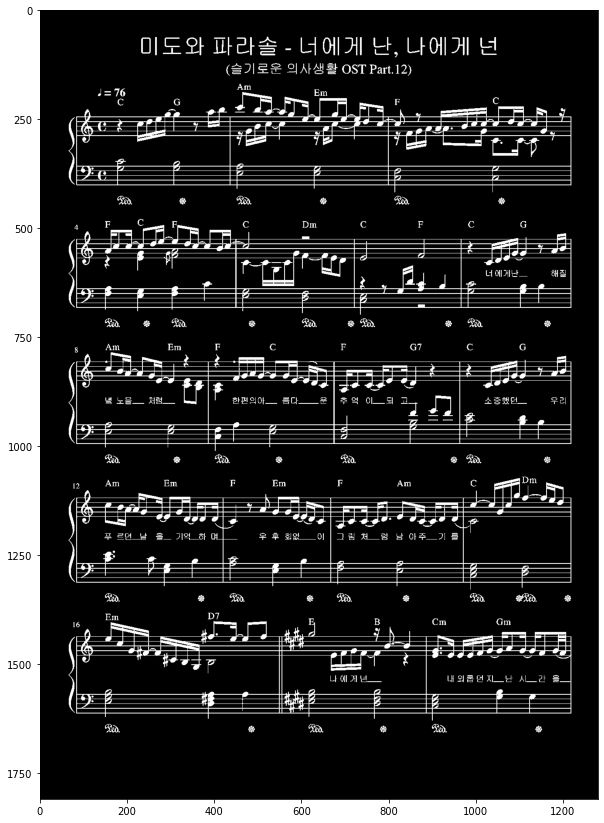

In [4]:
#Show sample
fs.plot_single_image(sample_image, off_axis=False)

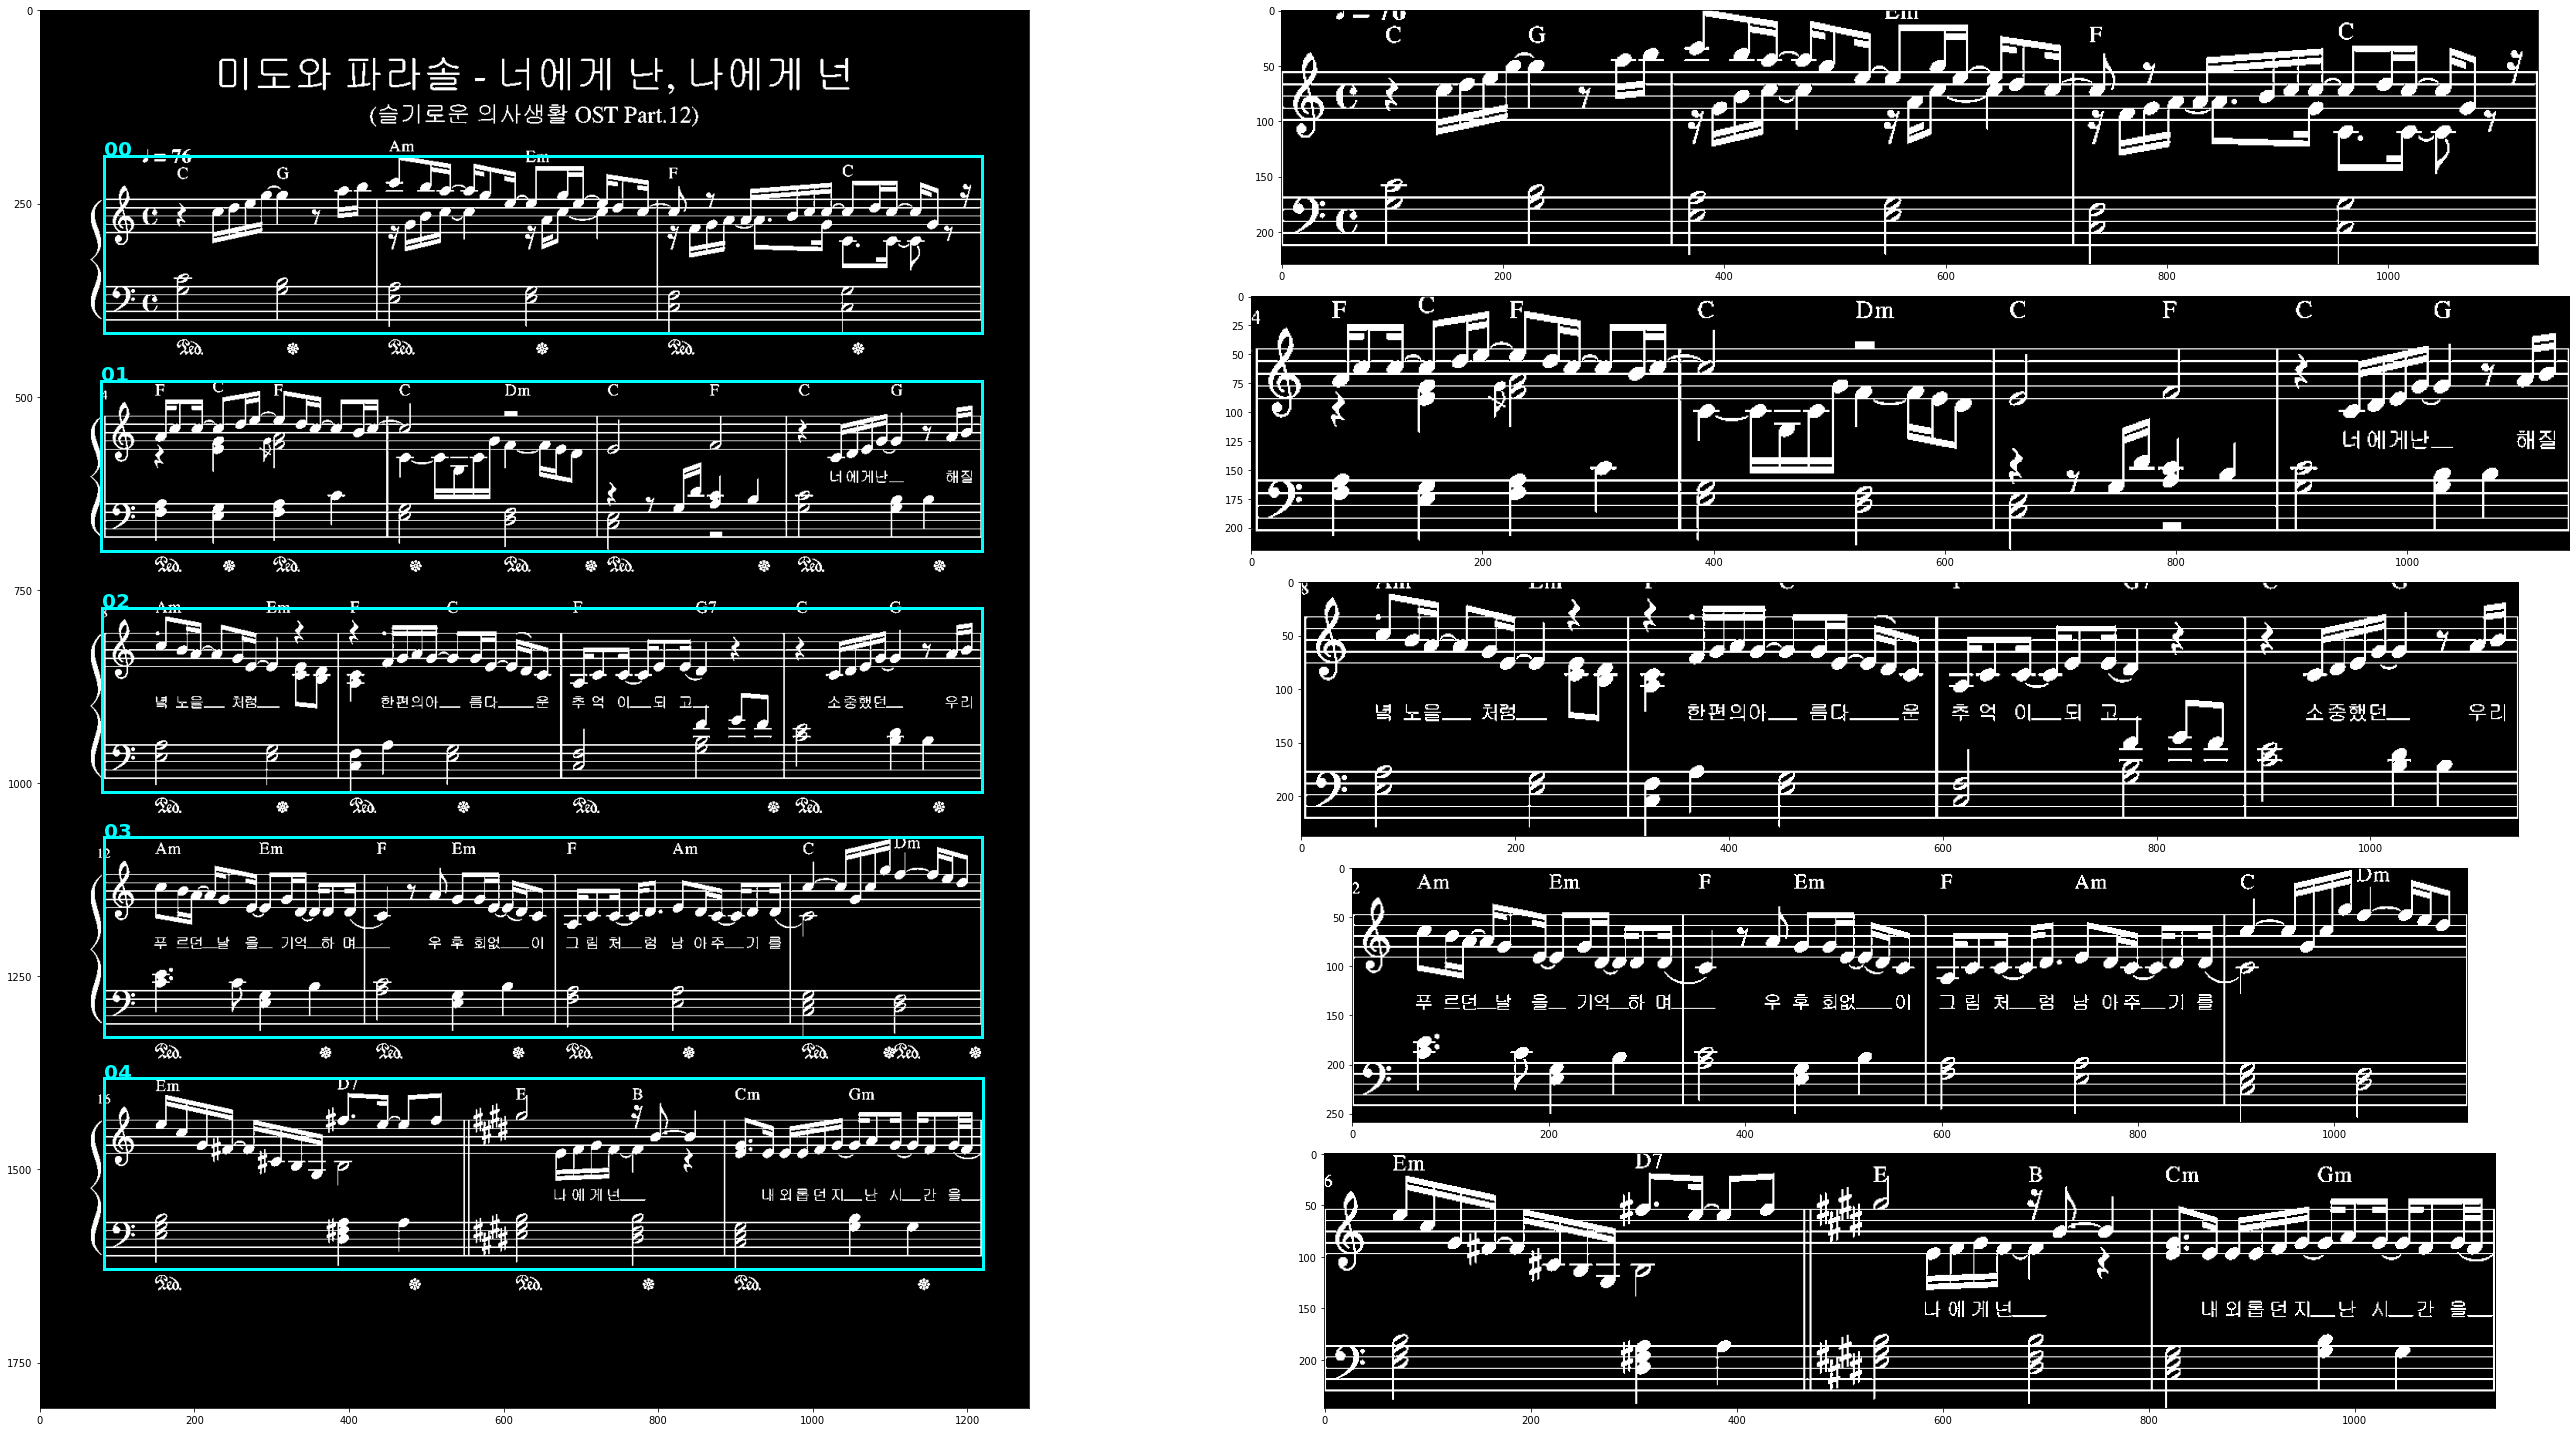

In [5]:
#Extract main components of sheet
main_components, pos, _ = fs.get_main_components(sample_image)
#Rearrange position of main components
main_components, pos = fs.arrange_components_idx(main_components, pos)

#Show show components
fig = plt.figure(figsize=(40,20))
ax = plt.subplot2grid((len(main_components), 2), (0, 0), rowspan=len(main_components))
ax.imshow(sample_image, cmap='gray')

for i, (x, y, w, h, area) in enumerate(pos):  #Highlighting
    ax.add_patch(patches.Rectangle((x, y), w, h, edgecolor='cyan', fill=False, linewidth=3))
    ax.text(x, y, f'{i:02d}', color='cyan', fontsize=20, fontweight='bold')

for i in range(len(main_components)):  #Show only component
    ax = plt.subplot2grid((len(main_components), 2), (i, 1))
    ax.imshow(main_components[i], cmap='gray')

fig.set_tight_layout(True)
plt.show() 

In [6]:
print('Extractable Object List')
print(*[k for k in pth.template.keys()], sep=' && ')

Extractable Object List
treble && bass && sharp && flat && quarter_note && half_note && whole_note && eighth_rest && quarter_rest && half_rest && whole_rest && barline && time


In [23]:
#Classifying symbols
cleves = ['treble', 'bass']
notes = ['quarter_note', 'half_note', 'whole_note']
rests = ['eighth_rest', 'quarter_rest', 'half_rest', 'whole_rest']

def show_templates(temp_dict):
    max_num_type = 0
    for v in temp_dict.values():
        max_num_type = max_num_type if len(v)<max_num_type else len(v)
    num_key = len(temp_dict.keys())
    
    fig = plt.figure(figsize=(2*max_num_type, 2*num_key))
    for i, (k, v) in enumerate(temp_dict.items()):
        for j, img in enumerate(v):
            ax = plt.subplot2grid((num_key, max_num_type), (i, j))
            ax.imshow(img, cmap='gray')
            ax.set_title(f'{k}-{j:02d}')
    fig.set_tight_layout(True)
    plt.show()    

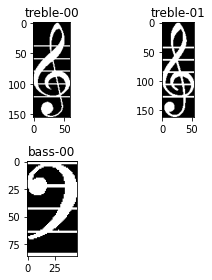

In [24]:
#show symbols - cleves
clef_templates = {k:pth.template[k] for k in cleves}
show_templates(clef_templates)

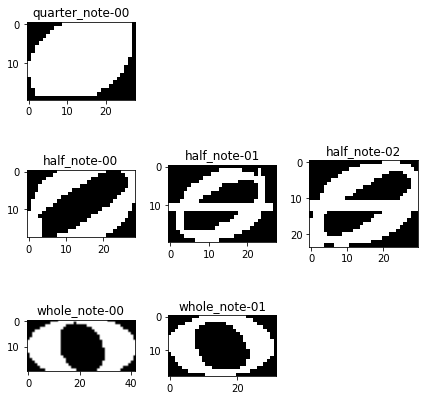

In [25]:
#show symbols - notes
note_templates = {k:pth.template[k] for k in notes}
show_templates(note_templates)


>>Target : Component : 00  -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
>>Find Clef - Treble
Treble :: pos : (x, y) = (11, 36), shape : (w, h)= (27, 81), best scale : 0.50, best score : 0.74
Update scale search domain : [min, max] = [0.25, 0.73]
>>Find Clef - Bass
Bass :: pos : (x, y) = (11, 169), shape : (w, h)= (23, 45), best scale : 0.52, best score : 0.69
>>Find Notes - quarter_note
Search result for quarter_note...
Template00 : 318->44 objects, scale : 0.52, shape : (10, 15), key score : 0.72
>>Find Notes - half_note
Search result for half_note...
Template00 : 38->11 objects, scale : 0.52, shape : (9, 15), key score : 0.70
Template01 : 9->5 objects, scale : 0.64, shape : (13, 18), key score : 0.70
Template02 : 7->4 objects, scale : 0.49, shape : (12, 15), key score : 0.75
>>Find Notes - whole_note
Search result for whole_note...
Template00 : 10->3 objects, scale : 0.25, shape : (5, 10), key score : 0.64
Template01 : 1->1 objects, scale : 0.52, shape : (9, 17), key score : 0.62
*Runti

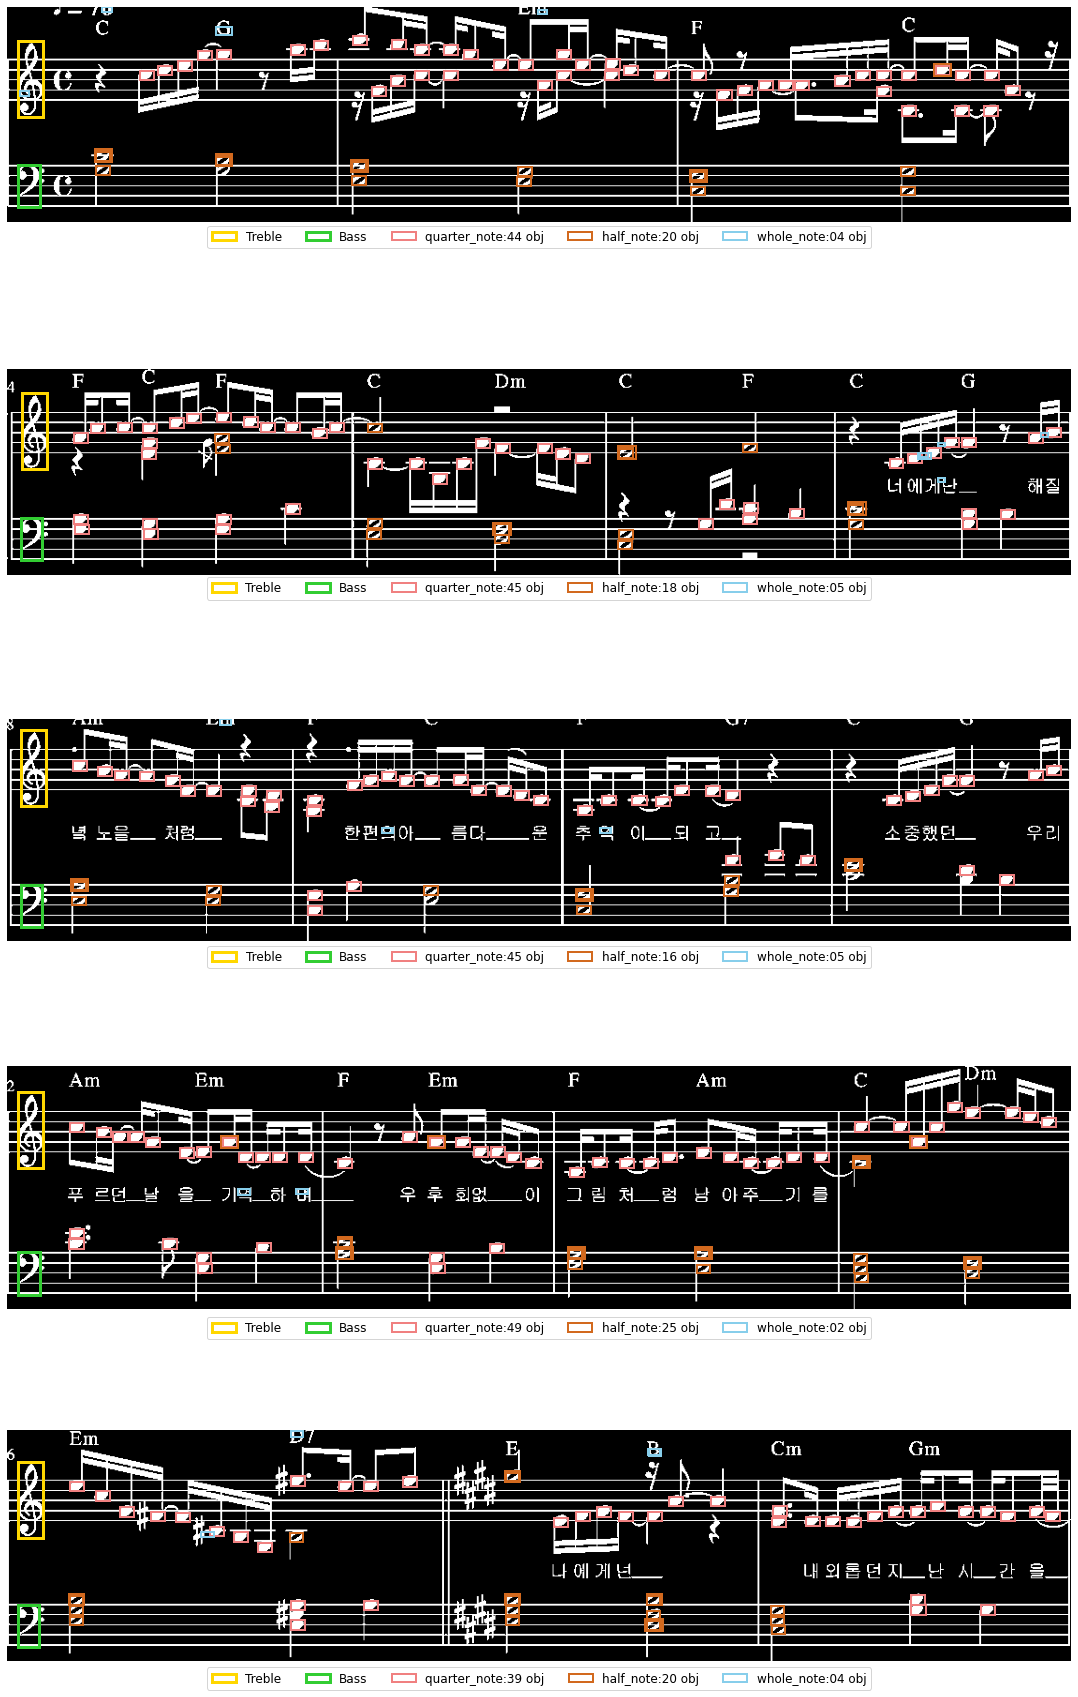

In [43]:
clist = ['lightcoral', 'chocolate', 'skyblue']
total_time = 0

fig = plt.figure(figsize=(30, 5*len(main_components)))
for i, component in enumerate(main_components):   
    ts = time.time()
    print('\n'+f'>>Target : Component : {i:02d}  '+'-='*20)
    
    ax = plt.subplot2grid((len(main_components), 2), (i, 0))
    ax.imshow(main_components[i], cmap='gray')
    
    #Find clef - treble
    print('>>Find Clef - Treble')
    score_t, scale_t, idx_t, shape_t, template_t = fs.find_best_match(component, pth.template["treble"], np.arange(0.5, 0.9, 0.03), search_area_ratio=3)
    print(f'Treble :: pos : (x, y) = {idx_t[::-1]}, shape : (w, h)= {shape_t[::-1]}, best scale : {scale_t:.2f}, best score : {score_t:.2f}')
    ax.add_patch(patches.Rectangle(idx_t[::-1], *shape_t[::-1], edgecolor='gold', fill=False, linewidth=3, label='Treble'))
    
    scale_list = np.arange(max(0.2, scale_t-0.25), scale_t+0.25, 0.03)
    print(f'Update scale search domain : [min, max] = [{np.min(scale_list):.2f}, {np.max(scale_list):.2f}]')
    
    #Find clef - bass
    print('>>Find Clef - Bass')
    score_b, scale_b, idx_b, shape_b, template_b = fs.find_best_match(component, pth.template["bass"], scale_list, search_area_ratio=3)
    print(f'Bass :: pos : (x, y) = {idx_b[::-1]}, shape : (w, h)= {shape_b[::-1]}, best scale : {scale_b:.2f}, best score : {score_b:.2f}')
    ax.add_patch(patches.Rectangle(idx_b[::-1], *shape_b[::-1], edgecolor='limegreen', fill=False, linewidth=3, label='Bass'))
    
    #Find Notes
    note_matches = {k:[] for k in note_templates.keys()}
    for j, (note_name, template_list) in enumerate(note_templates.items()):
        print(f'>>Find Notes - {note_name}')
        match_infos = fs.find_high_matches(component, template_list, scale_list[::-1], 0.6)
        print(f'Search result for {note_name}...')
        
        total_obj = 0
        for k, info in enumerate(match_infos):
            num_before = info['num']
            info = fs.non_maximum_suppression(info, threshold=0.3)
            print(f"Template{k:02d} : {num_before}->{info['num']} objects, scale : {info['scale']:.2f}, shape : {info['shape']}, key score : {info['key_score']:.2f}")
            note_matches[note_name].append(info)
            
            if info['num'] == 0:
                continue
            for y, x in zip(*info['location']):
                ax.add_patch(patches.Rectangle((x, y), *info['shape'][::-1],  edgecolor=clist[j], fill=False, linewidth=2))
            total_obj += info['num']
        ax.add_patch(patches.Rectangle((0,0), 0, 0, fill=False, edgecolor=clist[j], linewidth=2, label=f'{note_name}:{total_obj:02d} obj'))

    ax.legend(loc='lower center', fontsize='large', bbox_to_anchor=(0.5, -0.15), ncol=5)
    ax.axis('off')
    
    tf = time.time()
    print(f'*Runtime : {tf-ts:.2f} sec')
    total_time += tf-ts
print(f'###Total Runtime for {len(main_components)} components : {total_time:.2f} sec###')

fig.set_tight_layout(True)
plt.show() 